In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

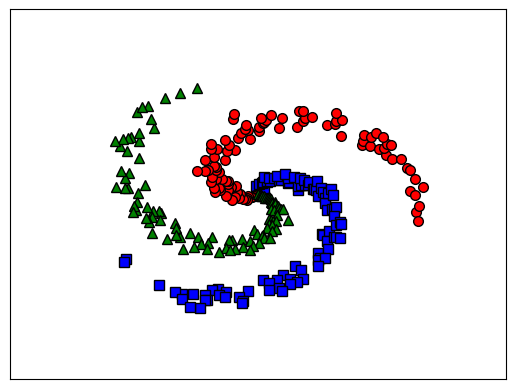

In [16]:
N = 100 # number of point per class
d0 = 2  # dimensionality
C = 3   # number of classes
X = np.zeros((N*C, d0))                 # data matrix (each row = single sample)
y = np.zeros(N*C, dtype = 'uint8')      # class labels

for j in range(C):
    idx = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[idx] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[idx] = j
  
plt.plot(X[0:N, 0], X[0:N, 1], 'bs', markersize=7, markeredgecolor='k');
plt.plot(X[N:2*N, 0], X[N:2*N, 1], 'ro', markersize=7, markeredgecolor='k');
plt.plot(X[2*N:3*N, 0], X[2*N:3*N, 1], 'g^', markersize=7, markeredgecolor='k');
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

ax = plt.gca()                          # get current axes
ax.axes.get_xaxis().set_ticks([])       # remove x-axis ticks
ax.axes.get_yaxis().set_ticks([])       # remove y-axis ticks
plt.show()

In [ ]:
def softmax_stable(Z : np.ndarray) -> np.ndarray:
    """
    Shape of Z : (N,C)
    N: number of points
    C: number of classes
    Compute softmax values for each sets of scores in Z.
    each row of Z is a set of scores.    
    """
    e_Z = np.exp(Z - np.max(Z, axis = 1, keepdims = True))
    A = e_Z / np.sum(e_Z, axis = 1, keepdims = True)
    return A

def crossentropy_loss(Yhat : np.ndarray, y : np.ndarray):
    """
    Yhat: a numpy array of shape (Npoints, nClasses) -- predicted output
    y: a numpy array of shape (Npoints) -- ground truth.
    NOTE: We don’t need to use the one-hot vector here since most of elements
    are zeros. When programming in numpy, in each row of Yhat, we need to access
    to the corresponding index only.
    """
    N = Yhat.shape[0]
    idx_axis_0 = np.arange(N)
    return -np.mean(np.log(Yhat[idx_axis_0, y]))
    

def mlp_init(d0 , d1, d2):
    """
    Initialize W1, b1, W2, b2
    d0: dimension of input data
    d1: number of hidden unit
    d2: number of output unit = number of classes
    """
    W1 = 0.01*np.random.randn(d0, d1)
    b1 = np.zeros(d1)
    W2 = 0.01*np.random.randn(d1, d2)
    b2 = np.zeros(d2)
    return (W1, b1, W2, b2)
    
def mlp_predict(X : np.ndarray, W1 : np.ndarray, b1 : np.ndarray, W2 : np.ndarray, b2 : np.ndarray) -> np.ndarray:
    """
    Suppose that the network has been trained, predict class of new points.
    X: data matrix, each ROW is one data point.
    W1, b1, W2, b2: learned weight matrices and biases
    Return an ndarray of predicted classes for new data points.
    """
    Z1 = (X @ W1) + b1
    A1 = np.maximum(Z1, 0)
    Z2 = (A1 @ W2) + b2
    return np.argmax(Z2, axis = 1)
    

def mlp_fit(X : np.ndarray, y : np.ndarray, W1 : np.ndarray, b1 : np.ndarray, W2 : np.ndarray, b2 : np.ndarray, eta = 1, n_epochs = 20000):
    """
    Trains a simple Multi-Layer Perceptron (MLP) model using gradient descent.
    This function updates the weights and biases of a two-layer neural network using a given learning rate. The MLP consists of:
    - An input layer
    - One hidden layer with ReLU
    - An output layer with Softmax

    Args:
        X (np.ndarray): Input data of shape (n_samples, n_features).
        y (np.ndarray): Target labels of shape (n_samples, ).
        W1,W2 (np.ndarray): Weight matrix of shape (d(l-1), d(l)).
        b1,b2 (np.ndarray): Bias vector (d(l), ).
        eta (float): Learning rate used for weight updates.
    """
    loss_hist = []
    progress_bar = tqdm(range(n_epochs), desc="Epochs progress")
    for epoch in progress_bar:
        # Feedforward
        Z1 = (X @ W1) + b1
        A1 = np.maximum(Z1, 0)  # ReLU activation
        Z2 = (A1 @ W2) + b2
        A2 = softmax_stable(Z2) # Softmax activation
        
        Yhat = A2
        loss_cur = crossentropy_loss(Yhat, y)
        loss_hist.append(loss_cur)
        if not ((epoch + 1) % 100):
            progress_bar.set_postfix(loss=f"{loss_cur:.6f}")
        
        # Backpropagation
        N = Yhat.shape[0]
        idx_axis_0 = np.arange(N)
        Y = np.zeros_like(Yhat, dtype = np.float32)
        Y[idx_axis_0, y] = 1
        E2 = (1/N)*(Yhat - Y)       # shape (N, d2)
        dW2 = (A1.T @ E2)           # shape (d1, d2)
        db2 = np.sum(E2, axis = 0)  # shape (d2, 1)
        E1 = (E2 @ W2.T)              # shape (N, d1)
        E1[Z1 <= 0]  = 0            # gradient of ReLU, shape (N, d1)
        dW1 = (X.T @ E1)            # shape (d0, d1)
        db1 = np.sum(E1, axis = 0)  # shape (d1, 1)
        
        # Gradient Descent update
        W1 -= eta*dW1
        b1 -= eta*db1
        W2 -= eta*dW2
        b2 -= eta*db2
        
    return (W1, b1, W2, b2, loss_hist)

In [31]:
d0 = 2          # data dimension
d1 = h = 200    # number of hidden units
d2 = C = 3      # number of classes
(W1, b1, W2, b2) = mlp_init(d0, d1, d2)
(W1, b1, W2, b2, loss_hist) = mlp_fit(X, y, W1, b1, W2, b2)

Epochs progress: 100%|██████████| 20000/20000 [00:31<00:00, 631.38it/s, loss=0.014874]


In [32]:
def accuracy_score(y_test : np.ndarray, y_pred : np.ndarray):
    y_test.reshape(y_test.shape)
    return np.mean(y_test == y_pred)

y_pred = mlp_predict(X, W1, b1, W2, b2)
print(f"Accuracy score: {accuracy_score(y, y_pred)*100:.2f}%")

Accuracy score: 99.33%


(14400, 2)


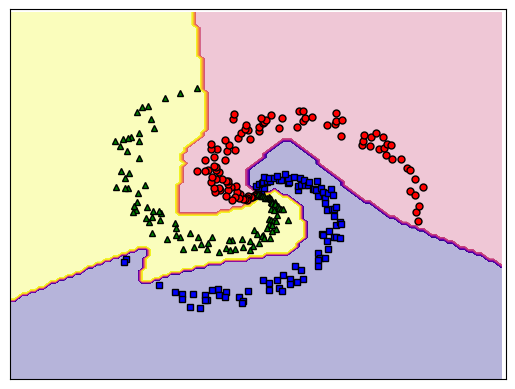

In [42]:
xm = np.arange(-1.5, 1.5, 0.025)
ym = np.arange(-1.5, 1.5, 0.025)
xx, yy = np.meshgrid(xm, ym)

xx1 = xx.ravel().reshape(-1, 1)  # x.ravel(): convert x to 1d-array
yy1 = yy.ravel().reshape(-1, 1)
XX = np.concatenate((xx1, yy1), axis = 1)
print(XX.shape)

pred = mlp_predict(XX, W1, b1, W2, b2)
pred = pred.reshape(xx.shape)

plt.clf()
plt.contourf(xx, yy, pred, 200, cmap = 'plasma', alpha = 0.3)

# Drawing data-point
plt.plot(X[0:N, 0], X[0:N, 1], 'bs', markersize=5, markeredgecolor='k');
plt.plot(X[N:2*N, 0], X[N:2*N, 1], 'ro', markersize=5, markeredgecolor='k');
plt.plot(X[2*N:3*N, 0], X[2*N:3*N, 1], 'g^', markersize=5, markeredgecolor='k');
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

ax = plt.gca()                          # get current axes
ax.axes.get_xaxis().set_ticks([])       # remove x-axis ticks
ax.axes.get_yaxis().set_ticks([])       # remove y-axis ticks

plt.xticks(())
plt.yticks(())
plt.show()